In [1]:
import numpy as np
import scipy.special as sc
import scipy.integrate as integrate
from scipy.optimize import fsolve

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 13})
matplotlib.rc('xtick', labelsize=13)
matplotlib.rc('ytick', labelsize=13)

In [2]:
# Quick search in an ordered matrix
def FastSearch_kl(m, n, target):
    row = 0
    col = m - 1

    # Traverse the matrix from (0, m-1):
    E = []
    while row < n and col >= 0:
        l = row+1
        k = col+1
        def G(x):
            return sc.betainc(k, m-k+1, sc.betainc(l, n-l+1, x))
        temp = 1-integrate.quad(G, 0, 1)[0]
        if temp < target:
            row += 1
        else:
            col -= 1
        E.append((temp, k, l))
    return np.array(E)

# Name of the algorithms
Algo1 = '$\\bf{QQM}$'
Algo2 = '$\\bf{QQM}$-$\\bf{Fast}$'
Algo3 = '$\\bf{QQC}$'
Algo4 = '$\\bf{QQC}$-$\\bf{Fast}$'
Algo5 = '$\\bf{QQM}$-$\\bf{n_j}$'
Algo6 = '$\\bf{QQC}$-$\\bf{n_j}$'
AlgoMNM = '$\\bf{QQM}$-$\\bf{(N/m)}$'
AlgoCNM = '$\\bf{QQC}$-$\\bf{(N/m)}$'

In [8]:
m = 20
n = 200

alpha = .1
beta = .2

In [9]:
# ============================= Fast approximation of Algo 1
E = FastSearch_kl(m, n, 1-alpha)

vv = min(i for i in E[:, 0] if i >= (1-alpha))
ind = np.where(E[:, 0] == vv)
k_A, l_A = int(E[ind, 1]), int(E[ind, 2])

print(k_A, l_A)

# ============================= Algo 2
M_k = np.zeros((n)) + 1
for l in np.arange(n, 0, -1):
    k_temp = int(np.ceil( (m+1/2)*( sc.betainc(l, n-l+1, 1-alpha)) + 1/2))
    if k_temp > m:
        break
    M_k[l-1] = sc.betaincinv(l, n-l+1, (k_temp)/(m+1/2))
    
l_AA = np.argmin(M_k)+1
k_AA = int(np.ceil( (m+1/2)*( sc.betainc(l_AA, n-l_AA+1, 1-alpha)) + 1/2))
print(k_AA, l_AA)

8 182
12 180


In [10]:
# ============================= Algo 3
M = np.zeros((m, n))
M2 = np.zeros((m, n))
for k in range(1, m+1):
    for l in range(1, n+1):
        M[k-1, l-1] = sc.betaincinv(l, n-l+1, sc.betaincinv(k, m-k+1, beta))
        M2[k-1, l-1] = sc.betaincinv(l, n-l+1, sc.betaincinv(k, m-k+1, 1-beta))

aa_r = np.ravel(M)
ind = np.where(aa_r >= 1-alpha)
aa_r2 = np.ravel(M2)[ind]
v = np.min(aa_r2)
k_M = int(np.where(M2 == v)[0])+1
l_M = int(np.where(M2 == v)[1])+1

print(k_M, l_M, M[k_M-1, l_M-1], 1-sc.betainc(k_M, m-k_M+1, sc.betainc(l_M, n-l_M+1, 1-alpha)))

# ============================= Algo 4
M_k = np.zeros((n))
for l in range(1, n+1):
    k_temp = int(np.ceil( (m+1)*( sc.betainc(l, n-l+1, 1-alpha) + np.sqrt(np.log(1/beta)/(2*(m+2))) ) ))
    M_k[l-1] = sc.betaincinv(l, n-l+1, sc.betaincinv(k_temp, m-k_temp+1, 1-beta))
    
v = min(i for i in M_k if i > (1-alpha))
l_e = int(np.where(M_k == v)[0])+1
ktilde = int(np.ceil( (m+1)*( sc.betainc(l_e, n-l_e+1, 1-alpha) + np.sqrt(np.log(1/beta)/(2*(m+2))) ) ))

print(ktilde, l_e, M_k[l_e-1], 1-sc.betainc(ktilde, m-ktilde+1, sc.betainc(l_e, n-l_e+1, 1-alpha)))

8 183 0.9003599786978574 0.8160005263233576
10 183 0.9151944560073725 0.9657631728643075


In [11]:
# Centralized methods

# Marginal
r_a = int(np.ceil((1-alpha)*(m*n+1)))
print(r_a)

# Training-cond (Fast)
f = lambda x: sc.betaincinv(x, m*n-x+1, beta)-(1-alpha)
r_a_cond = int(np.ceil(fsolve(f, [m*n//2])))
print(r_a_cond)

3601
3617


0.9000249937515621 0.004741704252049965 0.8960543748198047 0.9040344744962789
0.9001175378290897 0.006032457080785478 0.8950961264493389 0.9052249596132323
0.9006975115636551 0.005847952879873682 0.8958048869614479 0.9056374421249155


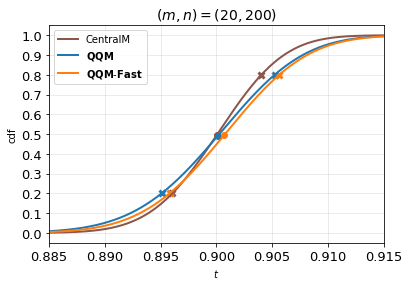

In [12]:
x = np.linspace(0.84, .95, 10000)

# ========================
# ========================
y = sc.betainc(r_a, m*n-r_a+1, x)
a = r_a; b = m*n-r_a+1
bb1 = sc.betaincinv(r_a, m*n-r_a+1, beta)
bb2 = sc.betaincinv(r_a, m*n-r_a+1, 1-beta)
print( r_a/(m*n+1), np.sqrt(a*b / ((a+b)**2 * (a+b+1))), bb1, bb2)
# ========================
plt.plot(x, y, label='CentralM', color='C5', linewidth=2)
plt.plot(r_a/(m*n+1), sc.betainc(r_a, m*n-r_a+1, r_a/(m*n+1)), 'o', color='C5')
plt.scatter(bb1, sc.betainc(r_a, m*n-r_a+1, bb1), marker="x", color='C5', linewidth=3)
plt.scatter(bb2, sc.betainc(r_a, m*n-r_a+1, bb2), marker="x", color='C5', linewidth=3)

# ========================
# ========================
y = sc.betainc(k_A, m-k_A+1, sc.betainc(l_A, n-l_A+1, x))
def G(x):
    return sc.betainc(k_A, m-k_A+1, sc.betainc(l_A, n-l_A+1, x))
mean = 1-integrate.quad(G, 0, 1)[0]
def H(x):
    return (1-sc.betainc(k_A, m-k_A+1, sc.betainc(l_A, n-l_A+1, x)))*x
moment2 = integrate.quad(H, 0, 1)[0]
bb1 = sc.betaincinv(l_A, n-l_A+1, sc.betaincinv(k_A, m-k_A+1, beta))
bb2 = sc.betaincinv(l_A, n-l_A+1, sc.betaincinv(k_A, m-k_A+1, 1-beta))
print(mean, np.sqrt(2*moment2-mean**2), bb1, bb2)
# ========================
plt.plot(x, y, label=Algo1, color='C0', linewidth=2)
plt.plot(mean, G(mean), 'o', color='C0')
plt.scatter(bb1, G(bb1), marker="x", color='C0', linewidth=3)
plt.scatter(bb2, G(bb2), marker="x", color='C0', linewidth=3)

# ========================
# ========================
y = sc.betainc(k_AA, m-k_AA+1, sc.betainc(l_AA, n-l_AA+1, x))
def G(x):
    return sc.betainc(k_AA, m-k_AA+1, sc.betainc(l_AA, n-l_AA+1, x))
mean = 1-integrate.quad(G, 0, 1)[0]
def H(x):
    return (1-sc.betainc(k_AA, m-k_AA+1, sc.betainc(l_AA, n-l_AA+1, x)))*x
moment2 = integrate.quad(H, 0, 1)[0]
bb1 = sc.betaincinv(l_AA, n-l_AA+1, sc.betaincinv(k_AA, m-k_AA+1, beta))
bb2 = sc.betaincinv(l_AA, n-l_AA+1, sc.betaincinv(k_AA, m-k_AA+1, 1-beta))
print(mean, np.sqrt(2*moment2-mean**2), bb1, bb2)
# ========================
plt.plot(x, y, label=Algo2, color='C1', linewidth=2)
plt.plot(mean, G(mean), 'o', color='C1')
plt.scatter(bb1, G(bb1), marker="x", color='C1', linewidth=3)
plt.scatter(bb2, G(bb2), marker="x", color='C1', linewidth=3)

plt.yticks(np.linspace(0, 1, 11))
plt.xlim((0.885, 0.915))
plt.grid(alpha=.3)
plt.xlabel('$t$')
plt.ylabel('cdf')

plt.legend(loc='upper left')
plt.title('$(m, n)=(' + str(m) + ',' + str(n) + ')$', fontdict={'fontsize': 14});

0.9040239940014996 0.004656212292337345 0.9001255793908608 0.9079616584314933
0.9052643955359942 0.005893678133106854 0.9003599786978574 0.9102551383592526
0.9104577769185345 0.0055984358188517465 0.905786883640705 0.9151944560073725


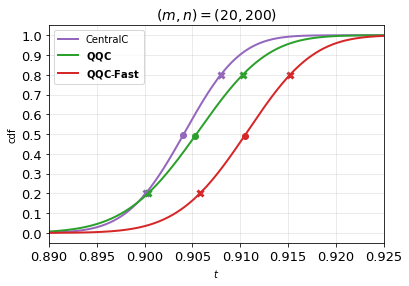

In [13]:
# ========================
# ========================
y = sc.betainc(r_a_cond, m*n-r_a_cond+1, x)
a = r_a_cond; b = m*n-r_a_cond+1
bb1 = sc.betaincinv(r_a_cond, m*n-r_a_cond+1, beta)
bb2 = sc.betaincinv(r_a_cond, m*n-r_a_cond+1, 1-beta)
print( r_a_cond/(m*n+1), np.sqrt(a*b / ((a+b)**2 * (a+b+1))), bb1, bb2)
# ========================
plt.plot(x, y, label='CentralC', color='C4', linewidth=2)
plt.plot(r_a_cond/(m*n+1), sc.betainc(r_a_cond, m*n-r_a_cond+1, r_a_cond/(m*n+1)), 'o', color='C4')
plt.scatter(bb1, sc.betainc(r_a_cond, m*n-r_a_cond+1, bb1), marker="x", color='C4', linewidth=3)
plt.scatter(bb2, sc.betainc(r_a_cond, m*n-r_a_cond+1, bb2), marker="x", color='C4', linewidth=3)

# ========================
# ========================
y = sc.betainc(k_M, m-k_M+1, sc.betainc(l_M, n-l_M+1, x))
def G(x):
    return sc.betainc(k_M, m-k_M+1, sc.betainc(l_M, n-l_M+1, x))
mean = 1-integrate.quad(G, 0, 1)[0]
def H(x):
    return (1-sc.betainc(k_M, m-k_M+1, sc.betainc(l_M, n-l_M+1, x)))*x
moment2 = integrate.quad(H, 0, 1)[0]
bb1 = sc.betaincinv(l_M, n-l_M+1, sc.betaincinv(k_M, m-k_M+1, beta))
bb2 = sc.betaincinv(l_M, n-l_M+1, sc.betaincinv(k_M, m-k_M+1, 1-beta))
print(mean, np.sqrt(2*moment2-mean**2), bb1, bb2)
# ========================
plt.plot(x, y, label=Algo3, color='C2', linewidth=2)
plt.plot(mean, G(mean), 'o', color='C2')
plt.scatter(bb1, G(bb1), marker="x", color='C2', linewidth=3)
plt.scatter(bb2, G(bb2), marker="x", color='C2', linewidth=3)

# ========================
# ========================
y = sc.betainc(ktilde, m-ktilde+1, sc.betainc(l_e, n-l_e+1, x))
def G(x):
    return sc.betainc(ktilde, m-ktilde+1, sc.betainc(l_e, n-l_e+1, x))
mean = 1-integrate.quad(G, 0, 1)[0]
def H(x):
    return (1-sc.betainc(ktilde, m-ktilde+1, sc.betainc(l_e, n-l_e+1, x)))*x
moment2 = integrate.quad(H, 0, 1)[0]
bb1 = sc.betaincinv(l_e, n-l_e+1, sc.betaincinv(ktilde, m-ktilde+1, beta))
bb2 = sc.betaincinv(l_e, n-l_e+1, sc.betaincinv(ktilde, m-ktilde+1, 1-beta))
print(mean, np.sqrt(2*moment2-mean**2), bb1, bb2)
# ========================
plt.plot(x, y, label=Algo4, color='C3', linewidth=2)
plt.plot(mean, G(mean), 'o', color='C3')
plt.scatter(bb1, G(bb1), marker="x", color='C3', linewidth=3)
plt.scatter(bb2, G(bb2), marker="x", color='C3', linewidth=3)

plt.yticks(np.linspace(0, 1, 11))
plt.xlim((0.89, 0.925))
plt.grid(alpha=.3)
plt.xlabel('$t$')
plt.ylabel('cdf')

plt.legend(loc='upper left')
plt.title('$(m, n)=(' + str(m) + ',' + str(n) + ')$', fontdict={'fontsize': 14});